In [26]:
import pandas as pd
import numpy as np

from sklearn import svm

from DyS_cvx import build_histograms

import utils as qntu

import os.path
import pickle

import pdb

from collections import Counter

from sklearn import preprocessing

from copy import deepcopy

In [2]:
from quantifiers.ACC import ACC
from quantifiers.PCC import PCC
from quantifiers.PACC import PACC
from quantifiers.HDy import HDy
from quantifiers.X import X
from quantifiers.MAX import MAX
from quantifiers.SMM import SMM  
from quantifiers.DyS import DyS
from quantifiers.SORD import SORD
from quantifiers.MS import MS
from quantifiers.T50 import T50
from quantifiers.EMQ import EMQ
from quantifiers.CC import CC
from quantifiers.DySyn import DySyn
from quantifiers.MS2 import MS2


def apply_quantifier(qntMethod, p_score, n_score,test_score, TprFpr, thr, measure, calib_clf, X_test, u_p, u_n):
  if qntMethod == "CC":
    return CC(test_score, thr)
  if qntMethod == "ACC":        
    return ACC(test_score, TprFpr)
  if qntMethod == "EMQ":
    tr_dist = [len(p_score), len(n_score)]
    tr_dist = np.round(tr_dist/np.sum(tr_dist),4)
    test_score = pd.concat([pd.DataFrame(test_score), pd.DataFrame(1-test_score)], axis=1)
    test_score.columns = ['1', '0']
    return EMQ(tr_dist, np.array(test_score))
  if qntMethod == "SMM":
    return SMM(p_score, n_score, test_score)
  if qntMethod == "HDy":
    return HDy(p_score, n_score, test_score)
  if qntMethod == "DyS":
    return DyS_SCH_cvx(p_score, n_score, test_score, measure)
  if qntMethod == "DySyn":
    return DySyn(test_score)
  if qntMethod == "DySyn2":
    return DySyn2(test_score)
  if qntMethod == "DySyn+aMoSS":
    return DySyn2_aMoSS(test_score, u_p, u_n)
  if qntMethod == "SORD":
    return SORD(p_score, n_score, test_score)
  if qntMethod == "MS":
    return MS(test_score, TprFpr)
  if qntMethod == "MAX":
    return MAX(test_score, TprFpr)
  if qntMethod == "X":
    return X(test_score, TprFpr)
  if qntMethod == "T50":
    return T50(test_score, TprFpr)
  if qntMethod == "PCC":
    return PCC(calib_clf, X_test,thr)
  if qntMethod == "PACC":
    return PACC(calib_clf, X_test, TprFpr, thr)


In [3]:
def DyS_SCH(pos_scores, neg_scores, test_scores, measure='topose'):
    
    #bin_size = np.linspace(10,10,1)
    bin_size = np.linspace(2,20,10)
    #bin_size = np.linspace(2,10,9)  #[10,20] range(10,111,10) #creating bins from 2 to 10 with step size 2
    bin_size = np.append(bin_size, 30)
    bin_size = bin_size.astype(int)
    
    result  = []
    score_range = (np.min(neg_scores), np.max(pos_scores))
    for bins in bin_size:
        #....Creating Histograms bins score\counts for validation and test set...............
        
        p_bin_count = np.histogram(pos_scores, bins=bins, range=score_range)[0]/len(pos_scores)
        n_bin_count = np.histogram(neg_scores, bins=bins, range=score_range)[0]/len(neg_scores)
        te_bin_count = np.histogram(test_scores, bins=bins, range=score_range)[0]/len(test_scores)

        #for x in range(0,len(alpha_values),1):
            
        #    vDist.append(qntu.DyS_distance(((p_bin_count*alpha_values[x]) + (n_bin_count*(1-alpha_values[x]))), te_bin_count, measure=measure))

        #result.append(alpha_values[np.argmin(vDist)])
        
        def f(x):            
            return(qntu.DyS_distance(((p_bin_count*x) + (n_bin_count*(1-x))), te_bin_count, measure = measure))
    
        result.append(qntu.TernarySearch(0, 1, f))                                           
                        
    pos_prop = round(np.median(result),2)
    return pos_prop

In [35]:
import math
import cvxpy as cvx

def DyS_SCH_cvx(pos_scores, neg_scores, test_scores, measure='topose'):
    
    #bin_size = np.linspace(10,10,1)
    bin_size = np.linspace(2,20,10)
    #bin_size = np.linspace(2,10,9)  #[10,20] range(10,111,10) #creating bins from 2 to 10 with step size 2
    bin_size = np.append(bin_size, 30)
    bin_size = bin_size.astype(int)
    
    result  = []
    score_range = (np.min(neg_scores), np.max(pos_scores))
    for bins in bin_size:
        #....Creating Histograms bins score\counts for validation and test set...............
        
        p_bin_count = np.histogram(pos_scores, bins=bins, range=score_range)[0]/len(pos_scores)
        n_bin_count = np.histogram(neg_scores, bins=bins, range=score_range)[0]/len(neg_scores)
        te_bin_count = np.histogram(test_scores, bins=bins, range=score_range)[0]/len(test_scores)

        #for x in range(0,len(alpha_values),1):
            
        #    vDist.append(qntu.DyS_distance(((p_bin_count*alpha_values[x]) + (n_bin_count*(1-alpha_values[x]))), te_bin_count, measure=measure))

        #result.append(alpha_values[np.argmin(vDist)])
        
        #def f(x):            
        #    return(qntu.DyS_distance(((p_bin_count*x) + (n_bin_count*(1-x))), te_bin_count, measure = measure))
        CM = np.concatenate([[n_bin_count], [p_bin_count]]).T
        
        p = cvx.Variable(2)
        constraints = [p >= 0, cvx.sum(p) == 1.0]
        problem = cvx.Problem(cvx.Minimize(cvx.sum(cvx.kl_div(2 * CM @ p, te_bin_count) +
                                                   cvx.kl_div(2 * te_bin_count, CM @ p))),
                              constraints)
        problem.solve(max_iters=10000)
        result.append(p.value[0])
        #result.append(qntu.TernarySearch(0, 1, f))                                           
                        
    pos_prop = round(np.median(result),2)
    return pos_prop

In [110]:
def get_batch (label, alpha, X_test, y_test, n):
    
    n_pos = int(np.round(n*alpha,0))
    n_neg = n - n_pos 
    
    i_pos = np.where(y_test == label)
    #X_pos = X_test.iloc[i_pos]
    X_pos = X_test[i_pos,:]
    #X_pos = X_pos.sample(n_pos)
    X_pos[np.random.randint(X_pos.shape[0], size=n_pos),:]

    

    y_pos = np.full((1,n_pos), label)[0]

    #X_neg = X_test.iloc[np.where(y_test != label)]
    X_neg = X_test[np.where(y_test != label)[0],:]

    dist_neg = np.random.uniform(0,1, len(np.unique(y_test))-1)
    
    dist_neg = dist_neg/np.sum(dist_neg)
    
    neg_labels = y_test[y_test != label]    

    if alpha == 1.0:
        dist_neg = np.array(dist_neg*(1-alpha))
        test = X_pos
        #dist_cl = np.zeros(len(y_test)+1)
        #np.append(np.unique(y_test[y_test != label]), label)
        dist_cl = np.append(dist_neg, alpha)[np.argsort(np.append(np.unique(neg_labels), label))]
        return test, None, dist_cl    
        
    neg_n = np.random.choice(np.unique(neg_labels), n_neg, p=dist_neg)
    labels, values = zip(*Counter(neg_n).items())    
    
    test = np.empty((0, X_neg.shape[1]))
    for i in range(0,len(labels)):        
        #aux = X_neg.iloc[np.where(neg_labels == labels[i])]
        
        aux = X_neg[np.where(neg_labels == labels[i])[0],:]

        test = np.concatenate([test,aux[np.random.randint(aux.shape[0], size=values[i]),:]])
        
        
        #test = pd.concat([test, aux.sample(values[i])], axis=0)
    
    #pdb.set_trace()
    #test = pd.concat([test, X_pos], axis=0)
    test = np.concatenate([test,X_pos[0]])  
    dist_neg = np.array(dist_neg*(1-alpha))  
    
    dist_cl = np.append(dist_neg, alpha)[np.argsort(np.append(np.unique(neg_labels), label))]   

    return test, np.append(np.array(neg_n), np.array(y_pos)), dist_cl

    


In [111]:
def training_OVR(X_train, y_train, label):
  train_pos = X_train[y_train == label,:]
  train_neg = X_train[y_train != label,:]

  #training_set = pd.concat([train_pos, train_neg], axis=0)
  
  training_set = np.concatenate((train_pos, train_neg)) 
  labels = np.zeros(len(y_train))
  labels[y_train == label] = 1
  labels = np.int0(labels)
  return training_set, labels


In [112]:
def run_expereiment(X_train, X_test, y_train, y_test, dts_name, models, l_scores):
  #>>>>>>>..............Experimental_setup............>>>>>>>>>>
  vdist = ["topsoe", "jensen_difference", "prob_symm", "ord", "sord", "hellinger"] 
  names_vdist = ["TS", "JD", "PS", "ORD", "SORD", "HD"] 
  counters    = ['DyS-TS']
  measure     = "topsoe"                   #default measure for DyS
  niterations = 10
  alpha_values = [0,0.1,0.2,0.3,0.4,0.6,0.7,0.8,0.9,1]

  y_test = pd.DataFrame(y_test)
  n_classes = np.sort(np.int0(np.unique(y_train)))
  print(n_classes)
  
  #X_test = X_test.reset_index()
  #y_test = y_test.reset_index()
  #y_test = y_test.drop(['index'], axis=1)
  #X_test = X_test.drop(['index'], axis=1)  

  #clf = RandomForestClassifier(n_estimators=200)
  clf= svm.SVC()
  
  if models is None:
    models = []
    l_scores = []
    l_train = []
    l_ytrain= []
    lbin = preprocessing.LabelBinarizer()
    y_bin = lbin.fit_transform(y_train)
    for ci in range(0,len(n_classes)):      
      #train_bin, y_bin = training_OVR(np.array(X_train), y_train, ci)
      clf.fit(X_train, y_bin[:,ci])
      models.append(deepcopy(clf))
      l_scores.append(qntu.getScores(X_train, y_bin[:,ci], 10, clf))
      l_train.append(X_train)
      l_ytrain.append(y_bin[:,ci])      

    pickle.dump(models, open('./models_scores/'+dts_name+'/models.sav', 'wb'))
    pickle.dump(l_scores, open('./models_scores/'+dts_name+'/l_scores.sav', 'wb'))
    pickle.dump(l_train, open('./models_scores/'+dts_name+'/l_train.sav', 'wb'))
    pickle.dump(l_ytrain, open('./models_scores/'+dts_name+'/l_ytrain.sav', 'wb'))
  else:
    models = pickle.load(open('./models_scores/'+dts_name+'/models.sav', 'rb'))
    l_scores = pickle.load(open('./models_scores/'+dts_name+'/l_scores.sav', 'rb'))
    l_train = pickle.load(open('./models_scores/'+dts_name+'/l_train.sav', 'rb'))
    l_ytrain = pickle.load(open('./models_scores/'+dts_name+'/l_ytrain.sav', 'rb'))
     
  result = pd.DataFrame()   
  
  batch_sizes = [50]
  table=pd.DataFrame()
  for sample_size in batch_sizes:   #[10,100,500], batch_sizes, Varying test set sizes 
    for cl in n_classes:
      for alpha in alpha_values:      
        for iter in range(niterations):
          #print('Sample size #%d' % (sample_size))
          print('iteration #%d' % (iter + 1))
          sample_test, _, prop_actual = get_batch(cl, alpha, X_test, y_test[0], sample_size)  
          for co in counters:
            aux = co.split("-")
            #print(co)
            quantifier = co
            if len(aux) > 1:
              quantifier = aux[0]
              measure = vdist[names_vdist.index(aux[1])]
            
            pred_dist = []

            aux = co.split('_')
            if len(aux) > 1:            
              #qnt1 = fit_quantifier_schumacher_github(aux[1], X_train, y_train)
              #pred_dist = predict_quantifier_schumacher_github(qnt1, sample_test) 
              pass
            else:
              for i in range(0, len(models)):
                clf = models[i]   
                #te_scores = clf.predict_proba(sample_test)[:,1]  #estimating test sample scores                
                te_scores = clf.decision_function(sample_test)  #estimating test sample scores               
                scores = l_scores[i]  
                tprfpr = None#qntu.getTPRandFPRbyThreshold(scores)           
                #.............Calling of Methods..................................................           
                pos_scores = scores[scores['label']==1]['score']
                neg_scores = scores[scores['label']==0]['score']
                u_p = np.mean(pos_scores)
                u_n = np.mean(neg_scores)

                pred_pos_prop = apply_quantifier(qntMethod = quantifier, p_score = pos_scores, n_score = neg_scores, test_score = te_scores, 
                                                TprFpr = tprfpr, thr = 0.5, measure = measure, calib_clf = None, X_test = sample_test, 
                                                u_p = u_p, u_n = u_n)         
              
                pred_pos_prop = round(pred_pos_prop,2)  #predicted class proportion
                pred_dist.append(pred_pos_prop)        
                
              #..............................RESULTS Evaluation.....................................
            aux_sum = np.sum(pred_dist)
            if aux_sum != 0.0:
              pred_dist = pred_dist/aux_sum

            pred_dist = np.round(pred_dist, 3)
            #abs_error = np.round(np.sum(abs(pred_dist - prop_actual))/len(n_classes),3) #absolute error  
            abs_error = np.round(np.sum(abs(pred_dist - prop_actual)),3)
            #abs_error = qp.error.absolute_error(pred_dist, prop_actual)    
            print(abs_error)

            line_result = pd.concat([pd.DataFrame([sample_size, abs_error, quantifier, dts_name]).T, pd.DataFrame(np.array(prop_actual)).T, pd.DataFrame(np.array(pred_dist)).T], axis=1)

            result = pd.concat([result, line_result], axis=0)

    co_names = ["Test_size","abs_error","quantifier", "dataset"]
    co_actual = ["actual_c."+ str(x) for x in np.unique(n_classes)]
    co_pred = ["pred_c."+ str(x) for x in np.unique(n_classes)]
    co_names.extend(co_actual)
    co_names.extend(co_pred) 

    result.columns = co_names  

  return result

In [113]:
X_train = np.load("scores/SkillCraft/Row1/Class1/X_train.npy")
y_train = np.load("scores/SkillCraft/Row1/Class1/y_train.npy")

X_test = np.load("scores/SkillCraft/Row1/Class1/X_test.npy")
y_test = np.load("scores/SkillCraft/Row1/Class1/y_test.npy")




run_expereiment(X_train, X_test, y_train, y_test, 'SkillCraft', None, None)

[1 2 3]
iteration #1


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


> <ipython-input-112-d167261f7f09>(96)run_expereiment()
     94 
     95                 pdb.set_trace()
---> 96                 pred_pos_prop = round(pred_pos_prop,2)  #predicted class proportion
     97                 pred_dist.append(pred_pos_prop)
     98 

0.38
> <ipython-input-112-d167261f7f09>(95)run_expereiment()
     93                                                 u_p = u_p, u_n = u_n)         
     94 
---> 95                 pdb.set_trace()
     96                 pred_pos_prop = round(pred_pos_prop,2)  #predicted class proportion
     97                 pred_dist.append(pred_pos_prop)

*** NameError: name 'abs_error' is not defined
[0.38]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


> <ipython-input-112-d167261f7f09>(96)run_expereiment()
     94 
     95                 pdb.set_trace()
---> 96                 pred_pos_prop = round(pred_pos_prop,2)  #predicted class proportion
     97                 pred_dist.append(pred_pos_prop)
     98 

[0.38, 1.0]
0.2
iteration #2


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


> <ipython-input-112-d167261f7f09>(95)run_expereiment()
     93                                                 u_p = u_p, u_n = u_n)         
     94 
---> 95                 pdb.set_trace()
     96                 pred_pos_prop = round(pred_pos_prop,2)  #predicted class proportion
     97                 pred_dist.append(pred_pos_prop)



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


> <ipython-input-112-d167261f7f09>(96)run_expereiment()
     94 
     95                 pdb.set_trace()
---> 96                 pred_pos_prop = round(pred_pos_prop,2)  #predicted class proportion
     97                 pred_dist.append(pred_pos_prop)
     98 

*** NameError: name 'error_abs' is not defined
0.2


BdbQuit: 

In [ ]:
l_scores = pickle.load(open('./models_scores/'+'SkillCraft'+'/l_scores.sav', 'rb'))

In [ ]:
import seaborn as sns

In [ ]:
l_scores[0]

,score,label
0,-1.264528,1
1,0.218064,1
2,-1.452301,1
3,-0.616858,1
4,-0.079966,1
...,...,...
1867,-1.112218,0
1868,-1.009145,0
1869,-1.585663,0
1870,-1.583538,0


<AxesSubplot:xlabel='score', ylabel='Count'>

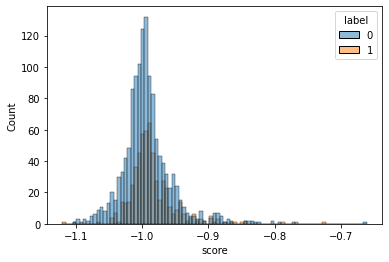

In [ ]:

sns.histplot(data=l_scores[2], x='score', hue='label')

In [ ]:
pd.DataFrame(y_train).value_counts()

2    936
3    562
1    374
dtype: int64

In [ ]:
X_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.454545,0.059524,0.00060,0.367136,0.169416,0.099522,0.0,0.021732,0.160142,0.253144,0.158444,0.550941,0.544980,0.344828,0.347251,0.384615,0.181809,0.223426
1,0.727273,0.119048,0.00025,0.195075,0.037449,0.264582,0.4,0.000000,0.053218,0.248951,0.282249,0.569724,0.383708,0.327586,0.088929,0.384615,0.000000,0.000000
2,0.477273,0.059524,0.00022,0.180356,0.047556,0.100551,0.5,0.032436,0.018386,0.321354,0.333717,0.397422,0.236301,0.396552,0.127283,0.692308,0.000000,0.000000
3,0.386364,0.071429,0.00064,0.299140,0.100830,0.251029,0.5,0.000000,0.138385,0.460284,0.211257,0.370201,0.271854,0.327586,0.233022,0.538462,0.061145,0.022363
4,0.431818,0.047619,0.00015,0.099532,0.000421,0.055009,0.3,0.000000,0.000000,0.332171,0.363639,0.460111,0.155010,0.310345,0.176086,0.461538,0.000000,0.035286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,0.409091,0.166667,0.00200,0.331288,0.061062,0.363847,0.4,0.025630,0.091808,0.645627,0.105525,0.244272,0.225869,0.603448,0.161552,0.692308,0.192973,0.156841
462,0.363636,0.166667,0.00050,0.516723,0.190668,0.230366,0.7,0.091462,0.152892,0.531245,0.138019,0.265928,0.369871,0.500000,0.364224,0.615385,0.191290,0.093284
463,0.545455,0.083333,0.00200,0.713690,0.607514,0.276289,0.2,0.030166,0.088916,0.532503,0.128542,0.269134,0.328164,0.379310,0.290078,0.538462,0.000000,0.000000
464,0.522727,0.035714,0.00150,0.544204,0.341340,0.555859,1.0,0.151725,0.150381,0.525340,0.116970,0.242508,0.324758,0.431034,0.132669,0.307692,0.000000,0.000000
